In [34]:
import math

In [35]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out


  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()



In [36]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'


In [37]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


In [38]:
a.grad = 6.000
b.grad = -4.000
c.grad = -2.000
d.grad = -2.000
e.grad = -2.000
f.grad = 4.000

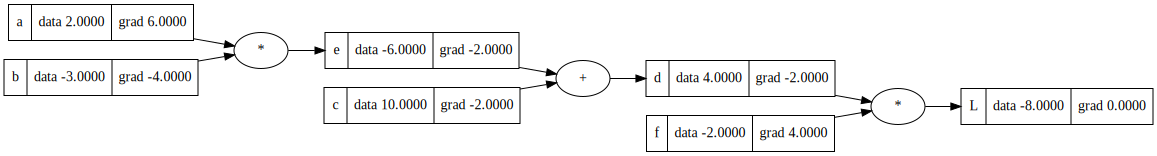

In [39]:
draw_dot(L)

In [40]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-7.286496


In [41]:
def lol():
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0+h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2-L1)/h)

lol()


6.000000000021544


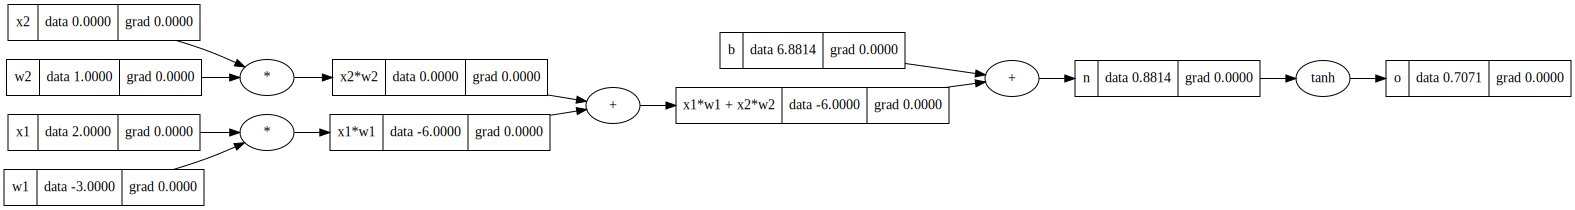

In [42]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

draw_dot(o)

In [43]:
# o.grad = 1.0
# o._backward()
# n._backward()
# b._backward()
# x1w1x2w2._backward()
# x2w2._backward()
# x1w1._backward()

# draw_dot(o)

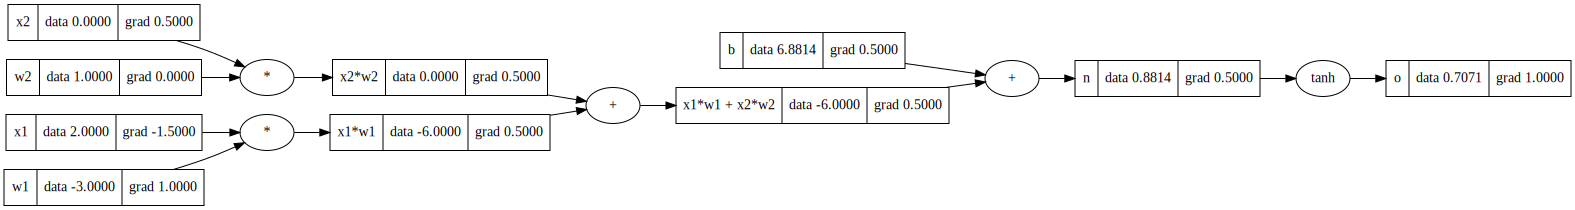

In [44]:
o.backward()
draw_dot(o)

In [48]:
import torch
import random

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()


0.7071066904050358


In [49]:

class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [50]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])

xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [51]:

for k in range(20):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad

  print(k, loss.data)


0 7.484593299895792
1 4.49704093336831
2 3.1986374926877374
3 2.607534612660909
4 2.1376522768865094
5 1.490208553392888
6 1.035534015852129
7 0.47823561570293993
8 0.04221720048350703
9 0.0368078870859051
10 0.03281868811497191
11 0.029714166961840958
12 0.02720584845802111
13 0.025123038218300774
14 0.02335737541945785
15 0.021836194617074055
16 0.02050858529014124
17 0.01933758431925675
18 0.018295553753091588
19 0.017361314329719928


In [52]:
ypred

[Value(data=0.9371510436423753),
 Value(data=-0.9526899691067607),
 Value(data=-0.9274175042289017),
 Value(data=0.9231568786487915)]